In [180]:
import tensorflow as tf
import pandas as pd
import numpy as np
from playlist_recommender.modelling import model_pipeline, utils
import joblib
import json
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from collections import Counter

In [181]:
def get_top_n_prediction_indices(prediction_array:np.array, n:int):
    return np.flip(np.argsort(prediction_array)[-n:])

In [182]:
def make_prediction(model, row, le_dict:dict):
    return le_dict[str(np.argmax(model.predict(row)))]   

In [183]:
def get_top_n_predictions(prediction_array:np.array, n:int, encoder_dict:dict):
    top_indices = get_top_n_prediction_indices(prediction_array, n)
    predictions_list = []
    for idx in top_indices:
       predictions_list.append(encoder_dict[str(idx)])
    return predictions_list

In [184]:
trained_model_dir = r"/Users/jamesmoro/Documents/Python/playlist-recommender/playlist_recommender/modelling/trained_nn_model"

In [185]:
model = tf.keras.models.load_model(trained_model_dir)

In [186]:
liked_songs_dir = r"/Users/jamesmoro/Documents/Python/playlist-recommender/playlist_recommender/data/liked_songs_df.pkl"
liked_songs = pd.read_pickle(liked_songs_dir)

In [187]:
liked_artists = liked_songs['artist_names'].to_list()
liked_tracks = liked_songs['track_names'].to_list()
zipped_artists_tracks = tuple(zip(liked_artists, liked_tracks))

In [188]:
pipeline = joblib.load("pipeline.pkl")

In [189]:
json_dir = r"/Users/jamesmoro/Documents/Python/playlist-recommender/playlist_recommender/modelling/wandb/neural_net/label_encoding.json"
with open(json_dir, 'r') as f:
  le_dict = json.load(f)

In [190]:
transformed = pipeline.transform(liked_songs)

In [191]:
predictions = model.predict(transformed)

21/21 [==============================] - 0s 4ms/step


In [192]:
top_3_predicted_labels = []
for array in predictions:
    _predictions_labels = get_top_n_predictions(array, 3, le_dict)
    top_3_predicted_labels.append(_predictions_labels)
top_3_predictions_dict = dict(zip(zipped_artists_tracks, top_3_predicted_labels))     

In [193]:
top_1_predicted_labels = []
for array in predictions:
    _predictions_labels = get_top_n_predictions(array, 1, le_dict)
    top_1_predicted_labels.append(_predictions_labels)
top_1_predictions_dict = dict(zip(zipped_artists_tracks, top_1_predicted_labels))     

In [196]:
top_1_predictions_dict

{('Elton John',
  'All The Girls Love Alice - Remastered 2014'): ['Summer Songs'],
 ('Brian Protheroe', 'Pinball'): ['Discovered Weekly'],
 ('Lo Moon', 'Dream Never Dies'): ['Discovered Weekly'],
 ('Nation of Language', 'Across That Fine Line'): ['Classic Rock'],
 ('Harvey Danger', 'Flagpole Sitta'): ['Summer Songs'],
 ('John Prine', 'Saddle in the Rain'): ['Summer Songs'],
 ('Cliff Richard', 'Devil Woman - 2001 Remaster'): ['Summer Songs'],
 ('Red Hot Chili Peppers', 'Black Summer'): ['Driving'],
 ('Foo Fighters', 'No Way Back'): ['Chill'],
 ('Foo Fighters', 'Big Me'): ['Chill'],
 ('John C. Cale and Nico Nico', 'Cinnamon Girl'): ['Discovered Weekly'],
 ('Willie Nelson', 'Blue Skies'): ['Discovered Weekly'],
 ('Supertramp', 'The Logical Song - Remastered 2010'): ['Summer Songs'],
 ('New Riders of the Purple Sage', 'Lonesome L.A. Cowboy'): ['Summer Songs'],
 ('Pet Shop Boys',
  "It's a Sin - 2001 Remaster"): ['The Only Living Boy in New York'],
 ('Wolf Alice', 'Smile'): ['Summer Songs']

In [194]:
top_1_predictions_values = list(
        itertools.chain.from_iterable(list(top_1_predictions_dict.values()))) 

<AxesSubplot:xlabel='count'>

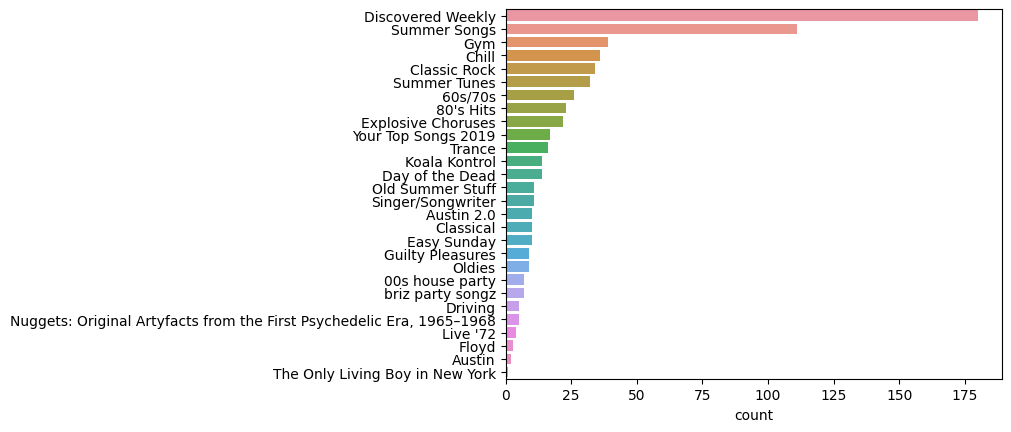

In [195]:
# fig, ax = plt.subplots(figsize = (12,8))
counts = Counter(top_1_predictions_values)
top_1_predictions_values = sorted(top_1_predictions_values, key=counts.get, reverse=True)
sns.countplot(y = top_1_predictions_values, orient= 'h',)
